In [1]:
import csv
import math
import os
import pickle
import scipy
import time
import zipfile

import numpy  as np
import pandas as pd
import tensorflow as tf

from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.layers import Dense, Lambda, Input
from keras.models import load_model, Model, model_from_json
from keras.optimizers import Adam, RMSprop
from keras.preprocessing import image
from keras import backend as K
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [2]:
INPUTS_FNAME   = "lfw_datasets_and_models.zip"

PATH_INPUTS_FNAME     = "./lfw_datasets_and_models.zip" 
PATH_INPUTS           = "./test/lfw_datasets_and_models"

PATH_DATASET_BASE     = PATH_INPUTS + "/datasets"

PATH_DATASET_BASE_MASKED   = PATH_DATASET_BASE + "/masked"
PATH_DATASET_BASE_UNMASKED = PATH_DATASET_BASE + "/unmasked"

PATH_DATASET_MASKED_TRAIN = PATH_DATASET_BASE_MASKED + "/train/"
PATH_DATASET_MASKED_VAL   = PATH_DATASET_BASE_MASKED + "/validation/"
PATH_DATASET_MASKED_TEST  = PATH_DATASET_BASE_MASKED + "/test/"

PATH_DATASET_UNMASKED_TRAIN = PATH_DATASET_BASE_UNMASKED + "/train/"
PATH_DATASET_UNMASKED_VAL   = PATH_DATASET_BASE_UNMASKED + "/validation/"
PATH_DATASET_UNMASKED_TEST  = PATH_DATASET_BASE_UNMASKED + "/test/"

PATH_TRAIN_RESNET = PATH_INPUTS + '/models/resnet'
PATH_TRAIN_FACENET = PATH_INPUTS + '/models/facenet'

PATH_FACENET_KERAS_H5 = PATH_INPUTS + "/models/facenet/keras-facenet/model/facenet_keras.h5"

In [3]:
def extract_zipfile(filename: str, extract_dirname: str, extract_path: str):
    # Extract the inputs from the zip file.
    if (not os.path.isdir(extract_dirname)):
        print("[INFO] Extracting from '{}' to '../'...".format(filename), end=" ")
        with zipfile.ZipFile(filename, "r") as zip_ref:
            zip_ref.extractall(extract_path)
        print("DONE.")
    else:
        print("[INFO] Directory '{}' exists.".format(extract_dirname))

#extract_zipfile(PATH_INPUTS_FNAME, PATH_INPUTS, "./")

In [4]:
# [Retraining]
TRAINING_IMAGES_COUNT = 265

masked_path = []
masked_dict = {}
unmasked_path = []
training_path = []
for subdir in os.listdir(PATH_DATASET_MASKED_TRAIN):
    filenames = os.listdir(PATH_DATASET_MASKED_TRAIN + subdir)
    filename = PATH_DATASET_MASKED_TRAIN + subdir + "/" + filenames[0]
    masked_path.append((subdir, filename))
    masked_dict[subdir] = filename

for subdir in os.listdir(PATH_DATASET_UNMASKED_TRAIN):
    filenames = os.listdir(PATH_DATASET_UNMASKED_TRAIN + subdir)
    filename = PATH_DATASET_UNMASKED_TRAIN + subdir + "/" + filenames[0]
    unmasked_path.append((subdir, filename))

print(len(masked_path))
print(len(unmasked_path))

masked_count = len(masked_path)
unmasked_count = len(unmasked_path)
neg = np.random.randint(masked_count, size=unmasked_count)
for i in range(TRAINING_IMAGES_COUNT):
    a_name, a_path = unmasked_path[i]
    if a_name not in masked_dict:
        continue
    pos_path = masked_dict[a_name]
    if (a_name != masked_path[neg[i]][0]):
        neg_path = masked_path[neg[i]][1]
    else:
        neg_path = masked_path[neg[i+1]][1]
    training_path.append((a_path, pos_path, neg_path))
        
print(len(training_path))

5721
5749
263


In [5]:
# [Retraing]
def triplet_loss(inputs, dist='euclidean', margin='maxplus'):
    anchor, positive, negative = inputs
    positive_distance = K.square(anchor - positive)
    negative_distance = K.square(anchor - negative)
    if dist == 'euclidean':
        positive_distance = K.sqrt(K.sum(positive_distance, axis=-1, keepdims=True))
        negative_distance = K.sqrt(K.sum(negative_distance, axis=-1, keepdims=True))
    elif dist == 'sqeuclidean':
        positive_distance = K.sum(positive_distance, axis=-1, keepdims=True)
        negative_distance = K.sum(negative_distance, axis=-1, keepdims=True)
    loss = positive_distance - negative_distance
    if margin == 'maxplus':
        loss = K.maximum(0.0, 1.8 + loss)
    elif margin == 'softplus':
        loss = K.log(1 + K.exp(loss))
        
    returned_loss = K.mean(loss)
    return returned_loss

In [6]:
# [Retraining]
# Used when compiling the siamese network
def identity_loss(y_true, y_pred):
    return K.mean(y_pred - 0 * y_true)  # This is actually just returning y_pred bcs
                                        # K.mean has already been called in the triplet_loss function

In [7]:
# [Retraining]
model = load_model(PATH_FACENET_KERAS_H5)
print(len(model.layers))
model.layers.pop()
model.layers.pop()
model.layers.pop()
model.summary()













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
426
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [8]:
layers_count = len(model.layers)
for i in range(layers_count):
    layer = model.layers[i]
    if i < layers_count//2:
        layer.trainable = False # Freeze first half of layers.
    elif layer.trainable and not layer.name.endswith("BatchNorm"):
        layer.trainable = False # Leave all BatchNorm layers to retrain.

last_layer = model.layers[layers_count - 1]
last_layer.trainable = True # Mark last layer to retrain.

#for layer in model.layers:
#    print(layer.name + " : " + str(layer.trainable))

In [9]:
# [Retraining]
# Define the siamese facenet network

image_shape = (160, 160, 3)

x = last_layer.output
model_out = Dense(128, activation='relu',  name='model_out')(x)
model_out = Lambda(lambda  x: K.l2_normalize(x, axis=-1))(model_out)

new_model = Model(inputs=model.input, outputs=model_out)

anchor_input = Input(shape=image_shape, name='anchor_input')
pos_input = Input(shape=image_shape, name='pos_input')
neg_input = Input(shape=image_shape, name='neg_input')

encoding_anchor = new_model(anchor_input)
encoding_pos = new_model(pos_input)
encoding_neg = new_model(neg_input)

loss = Lambda(triplet_loss)([encoding_anchor, encoding_pos, encoding_neg])

siamese_facenet = Model(inputs  = [anchor_input, pos_input, neg_input], outputs = loss)
siamese_facenet.compile(optimizer=Adam(lr=.05, clipnorm=1.), loss=identity_loss)
siamese_facenet.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
pos_input (InputLayer)          (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
neg_input (InputLayer)          (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 128)          22807888    anchor_input[0][0]               
                                                                 pos_input[0][0]                  
         

In [10]:
EPOCHS_COUNT = 25
BATCH_SIZE = 32

image_input_shape = (0, 160, 160, 3)
image_target_shape = (160, 160)
training_loss = []

for epoch in range(EPOCHS_COUNT):
    t = time.time()
    for batch in range(len(training_path)//BATCH_SIZE):
        anchor_imgs = np.empty(image_input_shape)
        pos_imgs = np.empty(image_input_shape)
        neg_imgs = np.empty(image_input_shape)
        start = batch * BATCH_SIZE
        end = start + BATCH_SIZE
        # print("    Batch from " + str(start) + " to " + str(end))
        for i in range (start, end):
            anchor_path, pos_path, neg_path = training_path[i]
            #print(anchor_path)
            anchor_img = image.load_img(anchor_path, target_size=image_target_shape)
            anchor_img = image.img_to_array(anchor_img)
            #print(anchor_imgs.shape)
            anchor_img = np.expand_dims(anchor_img, axis=0)
            #print(anchor_imgs.shape)
            anchor_img = preprocess_input(anchor_img)
            anchor_imgs = np.append(anchor_imgs, anchor_img, axis=0)
            #print(anchor_img.shape)

            #print(test_path)
            pos_img = image.load_img(pos_path, target_size=image_target_shape)
            pos_img = image.img_to_array(pos_img)
            pos_img = np.expand_dims(pos_img, axis=0)
            pos_img = preprocess_input(pos_img)
            pos_imgs = np.append(pos_imgs, pos_img, axis=0)
            #print(pos_img.shape)

            neg_img = image.load_img(neg_path, target_size=image_target_shape)
            neg_img = image.img_to_array(neg_img)
            neg_img = np.expand_dims(neg_img, axis=0)
            neg_img = preprocess_input(neg_img)
            neg_imgs = np.append(neg_imgs, neg_img, axis=0)
            #print(neg_img.shape)

        # dummy output, needed for being able to run the fit(..) function
        z = np.zeros(BATCH_SIZE)
        # print(len(z))
        siamese_facenet.fit(x=[anchor_imgs, pos_imgs, neg_imgs], 
                    y=z, 
                    batch_size=BATCH_SIZE, 
                    epochs=1, 
                    verbose=2, 
                    callbacks=None, 
                    validation_split=0.0, 
                    validation_data=None, 
                    shuffle=True, 
                    class_weight=None, 
                    sample_weight=None, 
                    initial_epoch=0, 
                    steps_per_epoch=None, 
                    validation_steps=None)
        training_loss.append(siamese_facenet.history.history['loss'])
    
    print("Epoch : " + str(epoch) + " Time taken : " + str(time.time() - t))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/1
 - 59s - loss: 1.7598
Epoch 1/1
 - 1s - loss: 1.7953
Epoch 1/1
 - 1s - loss: 1.7488
Epoch 1/1
 - 1s - loss: 1.7830
Epoch 1/1
 - 1s - loss: 1.7906
Epoch 1/1
 - 1s - loss: 1.7976
Epoch 1/1
 - 1s - loss: 1.7718
Epoch 1/1
 - 1s - loss: 1.7488
Epoch : 0 Time taken : 73.58878183364868
Epoch 1/1
 - 1s - loss: 1.6532
Epoch 1/1
 - 1s - loss: 1.3124
Epoch 1/1
 - 1s - loss: 1.3597
Epoch 1/1
 - 1s - loss: 1.3968
Epoch 1/1
 - 1s - loss: 1.4761
Epoch 1/1
 - 1s - loss: 1.5336
Epoch 1/1
 - 1s - loss: 1.5585
Epoch 1/1
 - 1s - loss: 1.5267
Epoch : 1 Time taken : 9.739009380340576
Epoch 1/1
 - 1s - loss: 1.4897
Epoch 1/1
 - 1s - loss: 1.1537
Epoch 1/1
 - 1s - loss: 1.2180
Epoch 1/1
 - 1s - loss: 1.1946
Epoch 1/1
 - 1s - loss: 1.3118
Epoch 1/1
 - 1s - loss: 1.3479
Epoch 1/1
 - 1s - loss: 1.3896
Epoch 1/1
 - 1s - loss: 1.3429
Epoch : 2 Time taken : 8.908381462097168
Epoch 1/1
 - 1s - loss: 1.3256
Epoch

In [11]:
# Training completed at this point. Save the model architecture and weights.
# Save the Siamese FaceNet Network architecture
siamese_model_json = siamese_facenet.to_json()
with open(PATH_TRAIN_FACENET + "/siamese_facenet_arch.json", "w") as json_file:
    json_file.write(siamese_model_json)
# save the Siamese Network model weights
siamese_facenet.save_weights(PATH_TRAIN_FACENET + "/siamese_facenet_weights.h5")

# create and save the Encoding Network to use in predictions later on
encoding_input = Input(shape=(160, 160, 3), name='facenet_encoding_input')
encoding_output = new_model(encoding_input)
encoding_facenet = Model(inputs  = encoding_input, outputs = encoding_output)

weights = siamese_facenet.get_layer('model_1').get_weights()
siamese_facenet.get_layer('model_1').set_weights(weights)

# Save the Encoding Network architecture
encoding_model_json = encoding_facenet.to_json()
with open(PATH_TRAIN_FACENET + "/encoding_facenet_arch.json", "w") as json_file:
    json_file.write(encoding_model_json)
# save the Encoding Network model weights    
encoding_facenet.save_weights(PATH_TRAIN_FACENET + '/encoding_facenet_weights.h5')

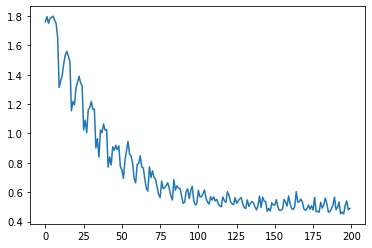

In [12]:
plt.figure()
plt.plot(training_loss)